<center><h1 style="color: #002c77; font-size: 28px"> Linear Regression - House Sales Dataset</h1></center>

<hr>

<center><h2>Importing libraries</center></h2>

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
%matplotlib inline

<hr>

<center><h2>Creating local functions</center></h2>

In [139]:
## Function removes the features that the model will not use,
## transform features into the proper format and create new
## features by combining other features (feature engineering)
def transform_features(dataframe, threshold):
    # create copy of original dataframe
    copy_dataframe = dataframe.copy()
    
    # iterate over each column and evaluate if there is more than
    # XX% nulls. If there is, drop the entire column
    print('Evaluating columns to drop')
    for col in copy_dataframe:
        number_nulls = copy_dataframe[col].isnull().sum()
        percentage_nulls = number_nulls/(len(copy_dataframe))
        if percentage_nulls > threshold:
            print('  Dropping', col, end='...')
            copy_dataframe.drop(col, axis=1, inplace=True)
            print('Ok')
        else:
            pass
    print('\n')
    float_int_cols = (copy_dataframe.
                      select_dtypes(include=['float',
                                             'int'])).columns
    print('Filling int and float cols')
    for col in float_int_cols:
        number_nulls = copy_dataframe[col].isnull().sum()
        percentage_nulls = number_nulls / len(copy_dataframe)
        if percentage_nulls < 0.05:
            print('  Imputing missing values in' + 
                  col + 'with mode', end='...')
            copy_dataframe[col].fillna(
                copy_dataframe[col].mode()[0],
                inplace=True)
            print('Ok')
        else:
            pass
    print('\n')
    
    print('Drop rows with any missing value in text columns',
          end='...')
    text_cols = (copy_dataframe.
                 select_dtypes(exclude=['float',
                                        'int'])).columns
    copy_dataframe.dropna(subset=text_cols,
                          axis=0,
                          inplace=True)
    print('Ok')
    print('\n')
    return copy_dataframe

In [140]:
def train_and_test(dataframe, split, model, target):
    train = dataframe[:split]
    test = dataframe[split:]
    model.fit(train.drop(target, axis=1), train[target])
    predictions_test = model.predict(test[target])
    rmse = np.sqrt(mean_squared_error(predictions_test,
                                      test[target]))
    return rmse

<hr>

<center><h2>Loading dataset</center></h2>

In [141]:
df = pd.read_csv(r'AmesHousing.tsv', sep='\t')

<hr>

<center><h2>Data Manipulation</center></h2>

### Data cleaning

The local function transform_features was written to:
- Drop any column with 0.05 (5%) or above of null entries
- Fill int and float columns with their mode (most frequent value in the column)
- Drop any rows with text columns null

In [142]:
cleaned_df = transform_features(df, 0.05)

Evaluating columns to drop
  Dropping Lot Frontage...Ok
  Dropping Alley...Ok
  Dropping Fireplace Qu...Ok
  Dropping Garage Type...Ok
  Dropping Garage Yr Blt...Ok
  Dropping Garage Finish...Ok
  Dropping Garage Qual...Ok
  Dropping Garage Cond...Ok
  Dropping Pool QC...Ok
  Dropping Fence...Ok
  Dropping Misc Feature...Ok


Filling int and float cols
  Imputing missing values inOrderwith mode...Ok
  Imputing missing values inPIDwith mode...Ok
  Imputing missing values inMS SubClasswith mode...Ok
  Imputing missing values inLot Areawith mode...Ok
  Imputing missing values inOverall Qualwith mode...Ok
  Imputing missing values inOverall Condwith mode...Ok
  Imputing missing values inYear Builtwith mode...Ok
  Imputing missing values inYear Remod/Addwith mode...Ok
  Imputing missing values inMas Vnr Areawith mode...Ok
  Imputing missing values inBsmtFin SF 1with mode...Ok
  Imputing missing values inBsmtFin SF 2with mode...Ok
  Imputing missing values inBsmt Unf SFwith mode...Ok
  Imput

### Feature engineering 

There are 2 new features that we can create:
- Number of years between the year it was sold and the last remodeling
- "Age" of the house when it was sold

In [143]:
## Create years before being sold column
cleaned_df['YEARS_BEFORE_SOLD'] = (cleaned_df['Yr Sold'] -
                                   cleaned_df['Year Built'])

## Create years before last remodeling
cleaned_df['YEARS_SINCE_REMODEL'] = (cleaned_df['Yr Sold'] -
                                     cleaned_df['Year Remod/Add'])

## Drop any rows that have negative values for these 2 new columns
cleaned_df = cleaned_df[(cleaned_df['YEARS_BEFORE_SOLD']>=0)&
                        (cleaned_df['YEARS_SINCE_REMODEL']>=0)]

## Drop original columns
cleaned_df.drop(['Year Built', 'Year Remod/Add'],
                axis=1, inplace=True)

### Feature selection

 - First, let's drop columns that (1) are not useful for the model and (2) represents data leakage:
1. PID, Order
2. Mo Sold, Sale Condition, Sale Type, Yr Sold

- Second, let's study the correlation between numerical columns and drop those who have a high correlation with the target column (SalePrice)


- Third, let's study the correlation between the feature columns and drop those who have a correlation higher than 0.7


- Fourth, let's study text columns and drop those who have more than 10 different entries (the remaining text column will be transformed into category and dummy columns)

In [144]:
not_useful = ['PID', 'Order']
leakage = ['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold']

## Drop columns that are not useful for the model
cleaned_df.drop(not_useful, axis=1, inplace=True)
cleaned_df.drop(leakage, axis=1, inplace=True)

In [145]:
## Slice dataframe to select only numerical columns
numerical_cleaned_df = cleaned_df.select_dtypes(include=['float',
                                                         'int'])

## Drop columns that have a correlation above 0.4
threshold = 0.4
corr = numerical_cleaned_df.corr().abs()['SalePrice']
cols_drop = corr[corr > 0.4].index
cols_drop = [i for i in cols_drop if 'SalePrice' not in i]
numerical_cleaned_df.drop(cols_drop,
                          axis=1,
                          inplace=True)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
threshold = 0.7
## Evaluate if the remaining columns have a high correlation
for col in numerical_cleaned_df.columns:
    correlations = numerical_cleaned_df.corr().abs()[col]
    corr_df = pd.DataFrame(correlations)
    indexes = [i for i in corr_df.index if col not in i]
    for ind in indexes:
        if corr_df.loc[ind][col] > threshold:
            print(ind, 'has a corr above',
                  threshold, 'with the', col, '\n')

In [147]:
## List of columns supposed to be categorical 
nominal_features = ["PID", "MS SubClass", "MS Zoning", 
                    "Street", "Alley", "Land Contour", 
                    "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", 
                    "Bldg Type", "House Style", "Roof Style", 
                    "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", 
                    "Foundation", "Heating", "Central Air", 
                    "Garage Type", "Misc Feature", 
                    "Sale Type", "Sale Condition"]

## Selecting columns with text
text_cleaned_df = cleaned_df.select_dtypes(exclude=['float',
                                                    'int'])
for col in text_cleaned_df.columns:
    if col in nominal_features:
        text_cleaned_df[col] = (text_cleaned_df[col].
                                astype('category'))
category_cleaned_df = (text_cleaned_df.
                       select_dtypes(include=['category']))
for col in category_cleaned_df:
    num_unique = category_cleaned_df[col].nunique()
    if num_unique>10:
        category_cleaned_df.drop(col, axis=1, inplace=True)

other_text_df = text_cleaned_df.select_dtypes(include=['object'])
for col in other_text_df.columns:
    other_text_df[col] = other_text_df[col].astype('category')

category_df_final = pd.concat([category_cleaned_df, 
                               other_text_df],
                               axis=1)

## Transform category dataframe into dummies
for col in category_df_final.columns:
    dummies = pd.get_dummies(category_df_final[col],
                             prefix=col, drop_first=True)
    category_df_final = pd.concat([category_df_final,
                                   dummies], axis=1)
    category_df_final.drop(col, axis=1, inplace=True)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

<hr>

<center><h2> Model Building</center></h2>

First, let's create our final cleaned dataframe and run our local function to evaluate the performance of our model

In [148]:
## Creating final dataframe
final_df = pd.concat([numerical_cleaned_df, category_df_final],
                     axis=1)

## Instantiate the model
model = LinearRegression()

## Define the target variable
target = 'SalePrice'

In [149]:
def train_and_test(dataframe, split, model, target, k):
    if k==0:
        train = dataframe[:split]
        test = dataframe[split:]
        model.fit(train.drop(target, axis=1), train[target])
        predictions_test = model.predict(test.drop(target, axis=1))
        rmse = np.sqrt(mean_squared_error(predictions_test,
                                          test[target]))
    if k==1:
        ## shuffle dataframe
        dataframe = dataframe.sample(frac=1).reset_index()
        fold_one = dataframe[:split]
        fold_two = dataframe[split:]
        rmses = []
        for fold in [fold_one, fold_two]:
            model.fit(fold.drop(target, axis=1),
                      fold[target])
            if fold.equals(fold_one):
                predictions = model.predict(fold_two.drop(target,
                                                          axis=1))
                rmse1 = np.sqrt(mean_squared_error(predictions,
                                                   fold_two[target]))
                rmses.append(rmse1)
            else:
                predictions = model.predict(fold_one.drop(target,
                                                          axis=1))
                rmse2 = np.sqrt(mean_squared_error(predictions,
                                                   fold_one[target]))
                rmses.append(rmse2)
                
            rmse = np.mean(rmses)
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmses = []
        for train_index, test_index in kf.split(dataframe):
            train = dataframe.iloc[train_index]
            test = dataframe.iloc[test_index]
            model.fit(train.drop(target, axis=1), train[target])
            predictions = model.predict(test.drop(target, axis=1))
            error = np.sqrt(mean_squared_error(predictions,
                                               test[target]))
            rmses.append(error)
        rmse = np.mean(rmses)
    return rmse

<hr>

<center><h2>Visualization for different K values</center></h2>

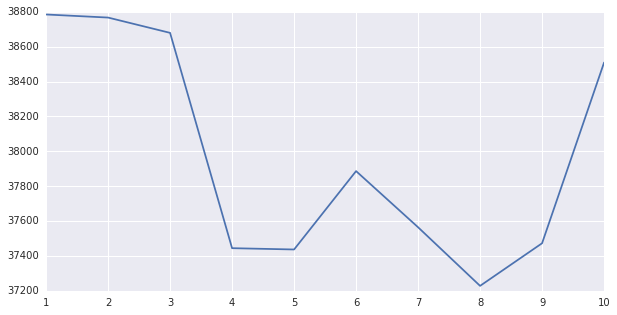

In [151]:
plt.figure(figsize=(10,5))
results = []
for k in range(1, 11):
    result = train_and_test(final_df, 1460, model, target, k)
    results.append(result)
    
plt.plot(range(1,11), results)

In [152]:
train_and_test(final_df, 1460, model, target, 8)

38923.99239247427

<hr>